---
# Step.0 Import Libraries

---

In [1]:
import os
from glob import glob
from tqdm import tqdm
import numpy as np
from typing import Tuple
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import (accuracy_score, confusion_matrix, classification_report,
                             roc_curve, auc)
from sklearn.preprocessing import label_binarize
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

from ml_models.data_loader import *
from ml_models.training import *
from ml_models.evaluation_utils import *
import joblib
from joblib import Parallel, delayed
import pandas as pd

---
# Three-Class Classification

In this notebook, we explore two classification methods , **Support Vector Machine (SVM)** and **Random Forest** , to categorize force levels into three classes: **Low**, **Medium**, and **High**.

## Workflow Summary

1. A 5-fold cross-validation setup was used, with data split into training and test sets.
2. Evaluation was performed on the test set, focusing on unseen participants.

---

### Step 1: Generate Folds and Define Data Directories


In [2]:
dataset_dir = "/Users/MA_Arash/MA_git/EIT_Thigh_Force_Estimation/Dataset/"

participants = ['P01','P02', 'P03', 'P04', 'P05', 'P06', 'P07', 'P08', 'P09', 
                'P10', 'P11', 'P12', 'P13', 'P14', 'P15']

folds = generate_random_folds(participants=participants, n_test=1, n_folds=5, seed=42)

class_names = ["low", "medium", "high"]
n_classes = len(class_names)

In [3]:
print(f"Number of classes: {n_classes}")
print(f"Class names: {class_names}")

print(f"Fold 0: {folds[0]}")

Number of classes: 3
Class names: ['low', 'medium', 'high']
Fold 0: (['P01', 'P02', 'P03', 'P04', 'P05', 'P06', 'P07', 'P08', 'P09', 'P10', 'P12', 'P13', 'P14', 'P15'], ['P11'])


In [4]:

# Lists for storing metrics across folds
acc_val = []
acc_test = []
fold_names = []

auc_val_list = [] 
auc_test_list = []


---
## Step 2: Support Vector Machines (SVM)

In this step, we train an SVM model using the **first fold** and apply **participant mean-free normalization**.  
Validation accuracy is computed, and both the **confusion matrix** and **classification report** are generated to evaluate performance.

Subsequently, **cross-validation on unseen participants** is performed, and the results are saved as a `.csv` file.  
This allows for a comparison between **global normalization** and **participant mean-free normalization** to assess their impact on classification performance.


---

In [9]:
## Lets Process the Folds 0

fold_index = 0
X_train, y_train, _ = load_dataset(participant=folds[fold_index][0], paths=dataset_dir, z_score_norm="participant_meanfree")

y_train_cat, y_train_lbl = assign_classification_labels(y_train)
X_test, y_test, _ = load_dataset(participant=folds[fold_index][1],paths=dataset_dir, z_score_norm="participant_meanfree")
y_test_cat, y_test_lbl = assign_classification_labels(y_test)

# Split training into train and validation
X_tr, X_val, y_tr, y_val = train_test_split(X_train, y_train_cat, test_size=0.2, random_state=42)

Loading participants: ['P01', 'P02', 'P03', 'P04', 'P05', 'P06', 'P07', 'P08', 'P09', 'P10', 'P12', 'P13', 'P14', 'P15']
Normalization method: participant_meanfree


Loading data:   7%|▋         | 1/14 [00:00<00:06,  1.95it/s]

PP01: mean-free → global z-scoring
   before: mean=-0.000, std=0.019
   after:  mean=0.000, std=1.000


Loading data:  14%|█▍        | 2/14 [00:01<00:09,  1.31it/s]

PP02: mean-free → global z-scoring
   before: mean=0.000, std=0.023
   after:  mean=0.000, std=1.000


Loading data:  21%|██▏       | 3/14 [00:02<00:10,  1.07it/s]

PP03: mean-free → global z-scoring
   before: mean=-0.000, std=0.017
   after:  mean=0.000, std=1.000


Loading data:  29%|██▊       | 4/14 [00:03<00:10,  1.00s/it]

PP04: mean-free → global z-scoring
   before: mean=-0.000, std=0.025
   after:  mean=-0.000, std=1.000


Loading data:  36%|███▌      | 5/14 [00:04<00:09,  1.09s/it]

PP05: mean-free → global z-scoring
   before: mean=-0.000, std=0.011
   after:  mean=0.000, std=1.000


Loading data:  43%|████▎     | 6/14 [00:06<00:08,  1.10s/it]

PP06: mean-free → global z-scoring
   before: mean=-0.000, std=0.024
   after:  mean=0.000, std=1.000


Loading data:  50%|█████     | 7/14 [00:07<00:07,  1.08s/it]

PP07: mean-free → global z-scoring
   before: mean=0.000, std=0.010
   after:  mean=-0.000, std=1.000


Loading data:  57%|█████▋    | 8/14 [00:08<00:06,  1.06s/it]

PP08: mean-free → global z-scoring
   before: mean=-0.000, std=0.021
   after:  mean=-0.000, std=1.000


Loading data:  64%|██████▍   | 9/14 [00:09<00:05,  1.08s/it]

PP09: mean-free → global z-scoring
   before: mean=-0.000, std=0.017
   after:  mean=0.000, std=1.000


Loading data:  71%|███████▏  | 10/14 [00:10<00:04,  1.11s/it]

PP10: mean-free → global z-scoring
   before: mean=-0.000, std=0.018
   after:  mean=-0.000, std=1.000


Loading data:  79%|███████▊  | 11/14 [00:11<00:03,  1.21s/it]

PP12: mean-free → global z-scoring
   before: mean=0.000, std=0.033
   after:  mean=-0.000, std=1.000


Loading data:  86%|████████▌ | 12/14 [00:13<00:02,  1.27s/it]

PP13: mean-free → global z-scoring
   before: mean=0.000, std=0.050
   after:  mean=-0.000, std=1.000


Loading data:  93%|█████████▎| 13/14 [00:14<00:01,  1.21s/it]

PP14: mean-free → global z-scoring
   before: mean=0.000, std=0.006
   after:  mean=0.000, std=1.000


Loading data: 100%|██████████| 14/14 [00:15<00:00,  1.10s/it]


PP15: mean-free → global z-scoring
   before: mean=-0.000, std=0.012
   after:  mean=0.000, std=1.000
low: 26072, medium: 26072, high: 26151
Loading participants: ['P11']
Normalization method: participant_meanfree


Loading data: 100%|██████████| 1/1 [00:01<00:00,  1.10s/it]

PP11: mean-free → global z-scoring
   before: mean=-0.000, std=0.013
   after:  mean=-0.000, std=1.000
low: 1849, medium: 1848, high: 1855


In [6]:
# Train the model
svm_model = build_svm_pipeline()
svm_model = train_pipeline(svm_model, X_tr, y_tr)

In [15]:
joblib.dump(svm_model, 'final_result/svm_model_fold0.pkl')

['final_result/svm_model_fold0.pkl']

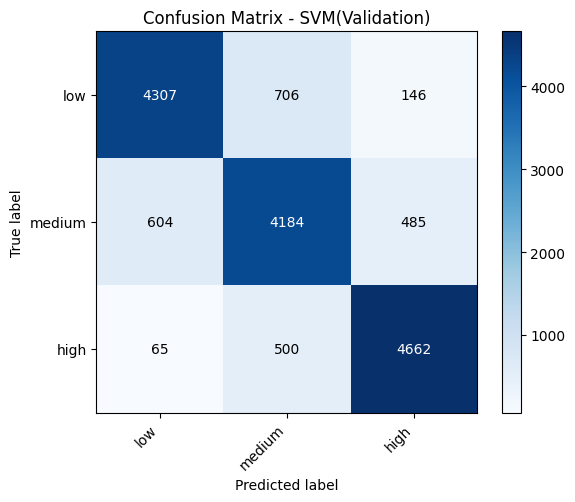

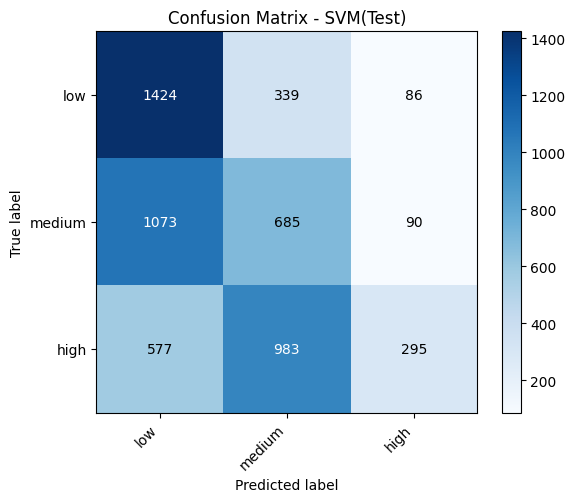

In [ ]:
# Evaluate the model
val_metrics = compute_metrics(svm_model, X_val, y_val, n_classes, class_names)

plot_confusion_matrix(val_metrics['conf_matrix'], class_names,
                          title=f"Confusion Matrix - SVM(Validation)", cmap="Blues", save_path="final_result/SVM_3cat_fold0.pdf")

# Evaluate test
test_metrics = compute_metrics(svm_model, X_test, y_test_cat, n_classes, class_names)
plot_confusion_matrix(test_metrics['conf_matrix'], class_names,
                          title=f"Confusion Matrix - SVM(Test)", cmap="Blues", save_path="final_result/SVM_3cat_fold0.pdf")


In [17]:
# save the fold 0

print(val_metrics["class_report"])
print(test_metrics["class_report"])

              precision    recall  f1-score   support

         low       0.87      0.83      0.85      5159
      medium       0.78      0.79      0.78      5273
        high       0.88      0.89      0.89      5227

    accuracy                           0.84     15659
   macro avg       0.84      0.84      0.84     15659
weighted avg       0.84      0.84      0.84     15659

              precision    recall  f1-score   support

         low       0.46      0.77      0.58      1849
      medium       0.34      0.37      0.36      1848
        high       0.63      0.16      0.25      1855

    accuracy                           0.43      5552
   macro avg       0.48      0.43      0.40      5552
weighted avg       0.48      0.43      0.40      5552



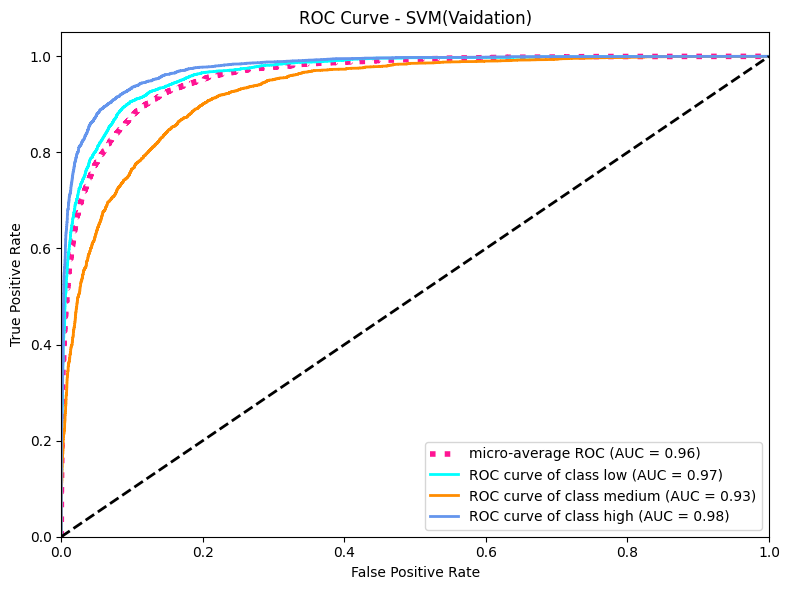

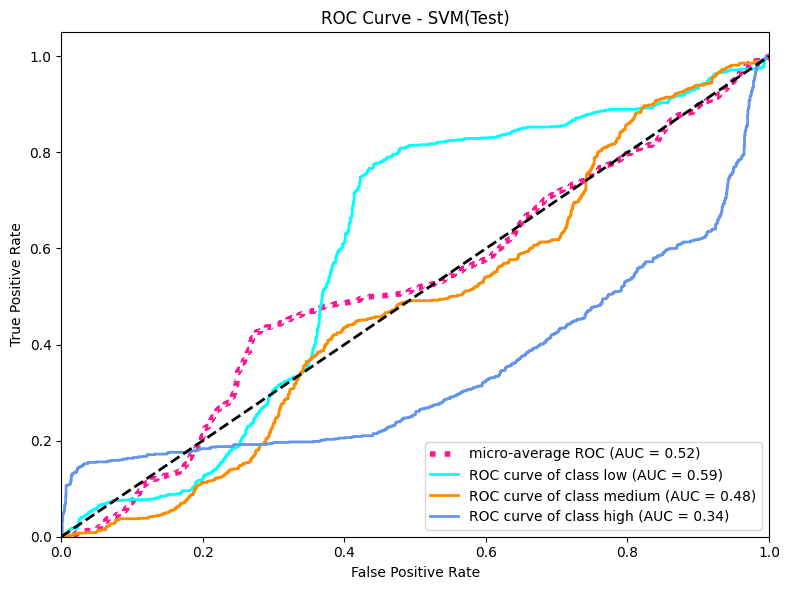

In [21]:
plot_roc_curves(val_metrics["roc"], n_classes=n_classes, class_names=class_names, title="ROC Curve - SVM(Vaidation)", save_path="final_result/SVM_3cat_fold0_roc_validation.pdf")

plot_roc_curves(test_metrics["roc"], n_classes=n_classes, class_names=class_names, title="ROC Curve - SVM(Test)", save_path="final_result/SVM_3cat_fold0_roc_test.pdf")


In [25]:
# Prepare data as a dictionary or list of dicts
metrics_to_save = {
    "val_accuracy": val_metrics["accuracy"],
    "roc_auc_micro": val_metrics["roc"]["auc"]["micro"],
    "test_accuracy": test_metrics["accuracy"],
    "roc_auc_micro_test": test_metrics["roc"]["auc"]["micro"],
    
}

# Convert to DataFrame and save
df = pd.DataFrame([metrics_to_save])
df.to_csv("final_result/fold0_metrics.csv", index=False)

## Lets play this cell tomorrow !!

Loading participants: ['P01', 'P03', 'P04', 'P05', 'P06', 'P07', 'P08', 'P09', 'P10', 'P11', 'P12', 'P13', 'P14', 'P15']
Normalization method: participant_meanfree


Loading data:   7%|▋         | 1/14 [00:00<00:05,  2.37it/s]

PP01: mean-free → global z-scoring
   before: mean=-0.000, std=0.019
   after:  mean=0.000, std=1.000


Loading data:  14%|█▍        | 2/14 [00:01<00:09,  1.22it/s]

PP03: mean-free → global z-scoring
   before: mean=-0.000, std=0.017
   after:  mean=0.000, std=1.000


Loading data:  21%|██▏       | 3/14 [00:02<00:10,  1.09it/s]

PP04: mean-free → global z-scoring
   before: mean=-0.000, std=0.025
   after:  mean=-0.000, std=1.000


Loading data:  29%|██▊       | 4/14 [00:03<00:10,  1.06s/it]

PP05: mean-free → global z-scoring
   before: mean=-0.000, std=0.011
   after:  mean=0.000, std=1.000


Loading data:  36%|███▌      | 5/14 [00:04<00:09,  1.08s/it]

PP06: mean-free → global z-scoring
   before: mean=-0.000, std=0.024
   after:  mean=0.000, std=1.000


Loading data:  43%|████▎     | 6/14 [00:05<00:08,  1.06s/it]

PP07: mean-free → global z-scoring
   before: mean=0.000, std=0.010
   after:  mean=-0.000, std=1.000


Loading data:  50%|█████     | 7/14 [00:06<00:07,  1.04s/it]

PP08: mean-free → global z-scoring
   before: mean=-0.000, std=0.021
   after:  mean=-0.000, std=1.000


Loading data:  57%|█████▋    | 8/14 [00:08<00:06,  1.07s/it]

PP09: mean-free → global z-scoring
   before: mean=-0.000, std=0.017
   after:  mean=0.000, std=1.000


Loading data:  64%|██████▍   | 9/14 [00:09<00:05,  1.08s/it]

PP10: mean-free → global z-scoring
   before: mean=-0.000, std=0.018
   after:  mean=-0.000, std=1.000


Loading data:  71%|███████▏  | 10/14 [00:10<00:04,  1.07s/it]

PP11: mean-free → global z-scoring
   before: mean=-0.000, std=0.013
   after:  mean=-0.000, std=1.000


Loading data:  79%|███████▊  | 11/14 [00:11<00:03,  1.12s/it]

PP12: mean-free → global z-scoring
   before: mean=0.000, std=0.033
   after:  mean=-0.000, std=1.000


Loading data:  86%|████████▌ | 12/14 [00:12<00:02,  1.17s/it]

PP13: mean-free → global z-scoring
   before: mean=0.000, std=0.050
   after:  mean=-0.000, std=1.000


Loading data:  93%|█████████▎| 13/14 [00:13<00:01,  1.13s/it]

PP14: mean-free → global z-scoring
   before: mean=0.000, std=0.006
   after:  mean=0.000, std=1.000


Loading data: 100%|██████████| 14/14 [00:14<00:00,  1.06s/it]


PP15: mean-free → global z-scoring
   before: mean=-0.000, std=0.012
   after:  mean=0.000, std=1.000
low: 26291, medium: 26290, high: 26369
Loading participants: ['P02']
Normalization method: participant_meanfree


Loading data: 100%|██████████| 1/1 [00:00<00:00,  1.16it/s]

PP02: mean-free → global z-scoring
   before: mean=0.000, std=0.023
   after:  mean=0.000, std=1.000
low: 1631, medium: 1630, high: 1636


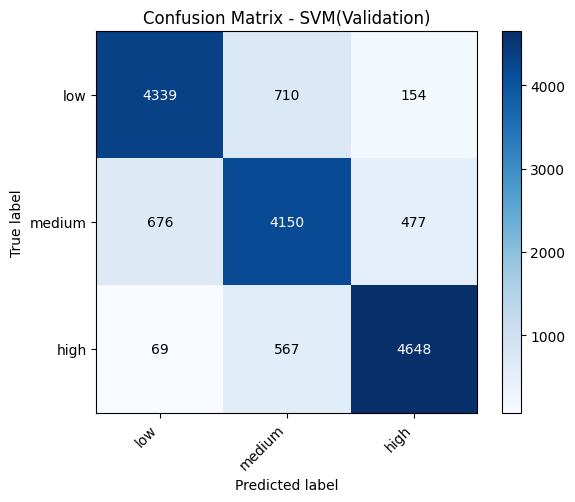

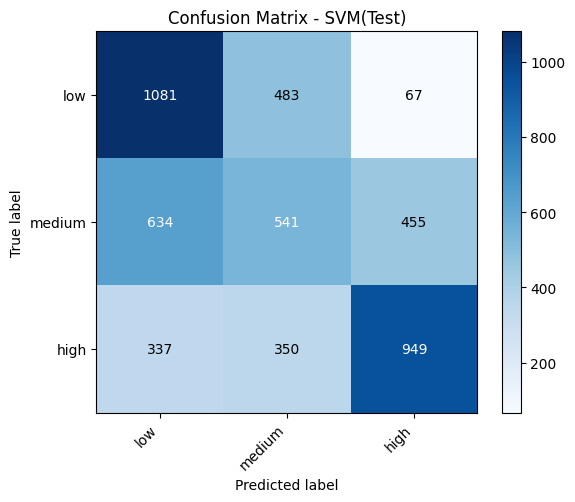

Loading participants: ['P02', 'P03', 'P04', 'P05', 'P06', 'P07', 'P08', 'P09', 'P10', 'P11', 'P12', 'P13', 'P14', 'P15']
Normalization method: participant_meanfree


Loading data:   7%|▋         | 1/14 [00:00<00:11,  1.09it/s]

PP02: mean-free → global z-scoring
   before: mean=0.000, std=0.023
   after:  mean=0.000, std=1.000


Loading data:  14%|█▍        | 2/14 [00:02<00:12,  1.04s/it]

PP03: mean-free → global z-scoring
   before: mean=-0.000, std=0.017
   after:  mean=0.000, std=1.000


Loading data:  21%|██▏       | 3/14 [00:03<00:11,  1.04s/it]

PP04: mean-free → global z-scoring
   before: mean=-0.000, std=0.025
   after:  mean=-0.000, std=1.000


Loading data:  29%|██▊       | 4/14 [00:04<00:11,  1.12s/it]

PP05: mean-free → global z-scoring
   before: mean=-0.000, std=0.011
   after:  mean=0.000, std=1.000


Loading data:  36%|███▌      | 5/14 [00:05<00:10,  1.13s/it]

PP06: mean-free → global z-scoring
   before: mean=-0.000, std=0.024
   after:  mean=0.000, std=1.000


Loading data:  43%|████▎     | 6/14 [00:06<00:08,  1.10s/it]

PP07: mean-free → global z-scoring
   before: mean=0.000, std=0.010
   after:  mean=-0.000, std=1.000


Loading data:  50%|█████     | 7/14 [00:07<00:07,  1.11s/it]

PP08: mean-free → global z-scoring
   before: mean=-0.000, std=0.021
   after:  mean=-0.000, std=1.000


Loading data:  57%|█████▋    | 8/14 [00:08<00:06,  1.12s/it]

PP09: mean-free → global z-scoring
   before: mean=-0.000, std=0.017
   after:  mean=0.000, std=1.000


Loading data:  64%|██████▍   | 9/14 [00:10<00:05,  1.19s/it]

PP10: mean-free → global z-scoring
   before: mean=-0.000, std=0.018
   after:  mean=-0.000, std=1.000


Loading data:  71%|███████▏  | 10/14 [00:11<00:04,  1.15s/it]

PP11: mean-free → global z-scoring
   before: mean=-0.000, std=0.013
   after:  mean=-0.000, std=1.000


Loading data:  79%|███████▊  | 11/14 [00:12<00:03,  1.21s/it]

PP12: mean-free → global z-scoring
   before: mean=0.000, std=0.033
   after:  mean=-0.000, std=1.000


Loading data:  86%|████████▌ | 12/14 [00:13<00:02,  1.25s/it]

PP13: mean-free → global z-scoring
   before: mean=0.000, std=0.050
   after:  mean=-0.000, std=1.000


Loading data:  93%|█████████▎| 13/14 [00:15<00:01,  1.22s/it]

PP14: mean-free → global z-scoring
   before: mean=0.000, std=0.006
   after:  mean=0.000, std=1.000


Loading data: 100%|██████████| 14/14 [00:16<00:00,  1.15s/it]


PP15: mean-free → global z-scoring
   before: mean=-0.000, std=0.012
   after:  mean=0.000, std=1.000
low: 27127, medium: 27127, high: 27208
Loading participants: ['P01']
Normalization method: participant_meanfree


Loading data: 100%|██████████| 1/1 [00:00<00:00,  1.66it/s]

PP01: mean-free → global z-scoring
   before: mean=-0.000, std=0.019
   after:  mean=0.000, std=1.000
low: 794, medium: 794, high: 797


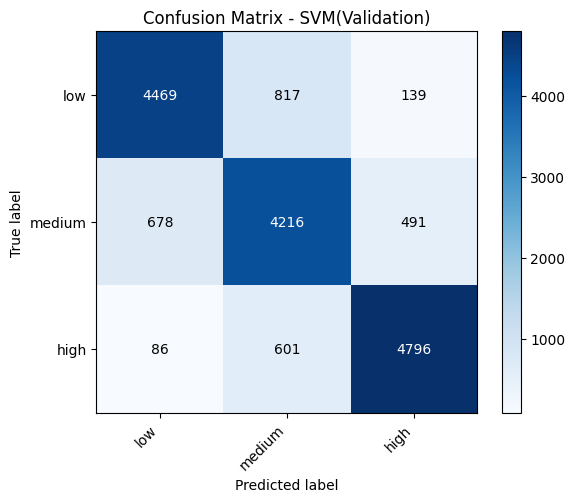

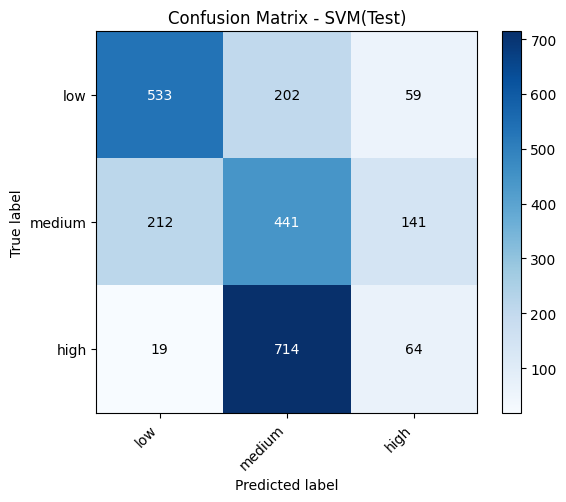

Loading participants: ['P01', 'P02', 'P03', 'P04', 'P05', 'P06', 'P07', 'P08', 'P09', 'P10', 'P11', 'P13', 'P14', 'P15']
Normalization method: participant_meanfree


Loading data:   7%|▋         | 1/14 [00:00<00:06,  2.05it/s]

PP01: mean-free → global z-scoring
   before: mean=-0.000, std=0.019
   after:  mean=-0.000, std=1.000


Loading data:  14%|█▍        | 2/14 [00:01<00:09,  1.32it/s]

PP02: mean-free → global z-scoring
   before: mean=0.000, std=0.023
   after:  mean=0.000, std=1.000


Loading data:  21%|██▏       | 3/14 [00:02<00:11,  1.03s/it]

PP03: mean-free → global z-scoring
   before: mean=-0.000, std=0.017
   after:  mean=0.000, std=1.000


Loading data:  29%|██▊       | 4/14 [00:04<00:11,  1.13s/it]

PP04: mean-free → global z-scoring
   before: mean=-0.000, std=0.025
   after:  mean=-0.000, std=1.000


Loading data:  36%|███▌      | 5/14 [00:05<00:11,  1.26s/it]

PP05: mean-free → global z-scoring
   before: mean=-0.000, std=0.011
   after:  mean=0.000, std=1.000


Loading data:  43%|████▎     | 6/14 [00:06<00:09,  1.23s/it]

PP06: mean-free → global z-scoring
   before: mean=-0.000, std=0.024
   after:  mean=0.000, std=1.000


Loading data:  50%|█████     | 7/14 [00:07<00:08,  1.17s/it]

PP07: mean-free → global z-scoring
   before: mean=0.000, std=0.010
   after:  mean=-0.000, std=1.000


Loading data:  57%|█████▋    | 8/14 [00:08<00:06,  1.15s/it]

PP08: mean-free → global z-scoring
   before: mean=-0.000, std=0.021
   after:  mean=-0.000, std=1.000


Loading data:  64%|██████▍   | 9/14 [00:10<00:05,  1.18s/it]

PP09: mean-free → global z-scoring
   before: mean=-0.000, std=0.017
   after:  mean=0.000, std=1.000


Loading data:  71%|███████▏  | 10/14 [00:11<00:04,  1.20s/it]

PP10: mean-free → global z-scoring
   before: mean=-0.000, std=0.018
   after:  mean=-0.000, std=1.000


Loading data:  79%|███████▊  | 11/14 [00:12<00:03,  1.20s/it]

PP11: mean-free → global z-scoring
   before: mean=-0.000, std=0.013
   after:  mean=-0.000, std=1.000


Loading data:  86%|████████▌ | 12/14 [00:13<00:02,  1.25s/it]

PP13: mean-free → global z-scoring
   before: mean=0.000, std=0.050
   after:  mean=-0.000, std=1.000


Loading data:  93%|█████████▎| 13/14 [00:15<00:01,  1.25s/it]

PP14: mean-free → global z-scoring
   before: mean=0.000, std=0.006
   after:  mean=0.000, std=1.000


Loading data: 100%|██████████| 14/14 [00:16<00:00,  1.17s/it]


PP15: mean-free → global z-scoring
   before: mean=-0.000, std=0.012
   after:  mean=0.000, std=1.000
low: 25819, medium: 25819, high: 25897
Loading participants: ['P12']
Normalization method: participant_meanfree


Loading data: 100%|██████████| 1/1 [00:01<00:00,  1.34s/it]

PP12: mean-free → global z-scoring
   before: mean=0.000, std=0.033
   after:  mean=-0.000, std=1.000
low: 2102, medium: 2102, high: 2108


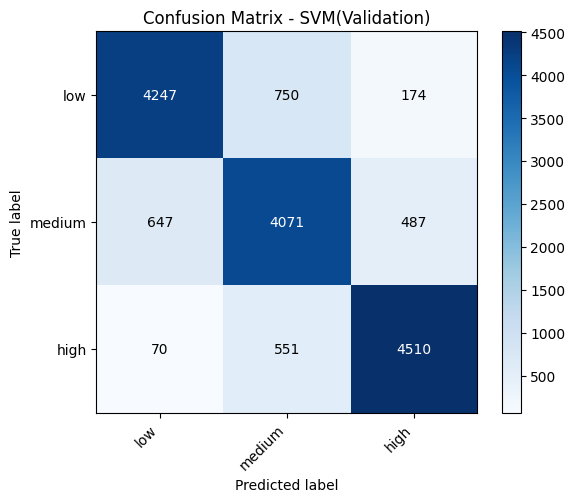

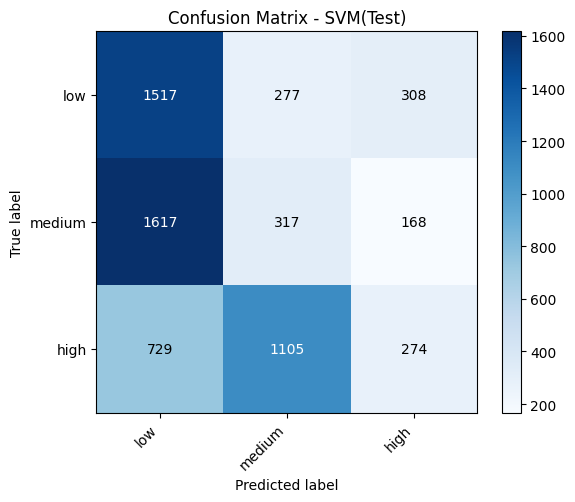

Loading participants: ['P01', 'P02', 'P03', 'P04', 'P06', 'P07', 'P08', 'P09', 'P10', 'P11', 'P12', 'P13', 'P14', 'P15']
Normalization method: participant_meanfree


Loading data:   7%|▋         | 1/14 [00:00<00:05,  2.23it/s]

PP01: mean-free → global z-scoring
   before: mean=-0.000, std=0.019
   after:  mean=0.000, std=1.000


Loading data:  14%|█▍        | 2/14 [00:01<00:08,  1.41it/s]

PP02: mean-free → global z-scoring
   before: mean=0.000, std=0.023
   after:  mean=0.000, std=1.000


Loading data:  21%|██▏       | 3/14 [00:02<00:09,  1.12it/s]

PP03: mean-free → global z-scoring
   before: mean=-0.000, std=0.017
   after:  mean=0.000, std=1.000


Loading data:  29%|██▊       | 4/14 [00:03<00:09,  1.06it/s]

PP04: mean-free → global z-scoring
   before: mean=-0.000, std=0.025
   after:  mean=-0.000, std=1.000


Loading data:  36%|███▌      | 5/14 [00:04<00:09,  1.02s/it]

PP06: mean-free → global z-scoring
   before: mean=-0.000, std=0.024
   after:  mean=0.000, std=1.000


Loading data:  43%|████▎     | 6/14 [00:05<00:08,  1.02s/it]

PP07: mean-free → global z-scoring
   before: mean=0.000, std=0.010
   after:  mean=-0.000, std=1.000


Loading data:  50%|█████     | 7/14 [00:06<00:07,  1.03s/it]

PP08: mean-free → global z-scoring
   before: mean=-0.000, std=0.021
   after:  mean=-0.000, std=1.000


Loading data:  57%|█████▋    | 8/14 [00:07<00:06,  1.07s/it]

PP09: mean-free → global z-scoring
   before: mean=-0.000, std=0.017
   after:  mean=0.000, std=1.000


Loading data:  64%|██████▍   | 9/14 [00:09<00:05,  1.09s/it]

PP10: mean-free → global z-scoring
   before: mean=-0.000, std=0.018
   after:  mean=-0.000, std=1.000


Loading data:  71%|███████▏  | 10/14 [00:10<00:04,  1.09s/it]

PP11: mean-free → global z-scoring
   before: mean=-0.000, std=0.013
   after:  mean=-0.000, std=1.000


Loading data:  79%|███████▊  | 11/14 [00:11<00:03,  1.15s/it]

PP12: mean-free → global z-scoring
   before: mean=0.000, std=0.033
   after:  mean=-0.000, std=1.000


Loading data:  86%|████████▌ | 12/14 [00:12<00:02,  1.18s/it]

PP13: mean-free → global z-scoring
   before: mean=0.000, std=0.050
   after:  mean=-0.000, std=1.000


Loading data:  93%|█████████▎| 13/14 [00:13<00:01,  1.20s/it]

PP14: mean-free → global z-scoring
   before: mean=0.000, std=0.006
   after:  mean=0.000, std=1.000


Loading data: 100%|██████████| 14/14 [00:15<00:00,  1.08s/it]


PP15: mean-free → global z-scoring
   before: mean=-0.000, std=0.012
   after:  mean=0.000, std=1.000
low: 25730, medium: 25730, high: 25808
Loading participants: ['P05']
Normalization method: participant_meanfree


Loading data: 100%|██████████| 1/1 [00:01<00:00,  1.53s/it]

PP05: mean-free → global z-scoring
   before: mean=-0.000, std=0.011
   after:  mean=0.000, std=1.000
low: 2191, medium: 2190, high: 2198


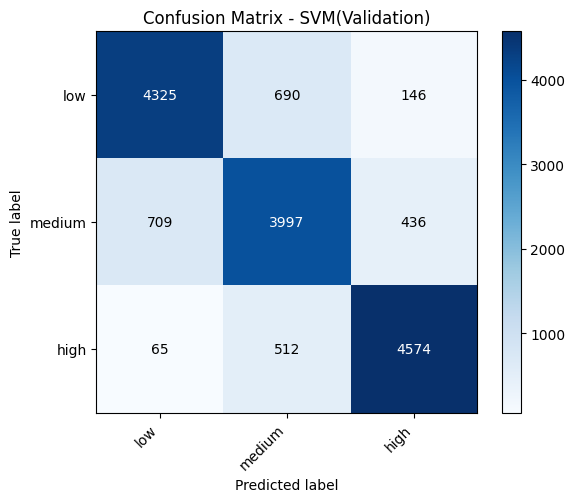

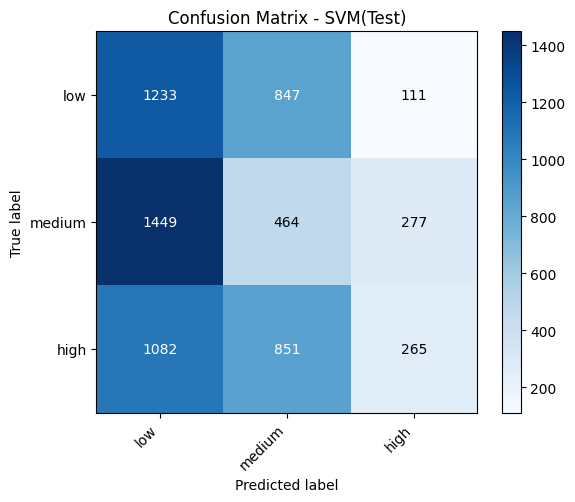

In [4]:
val_acc = []
test_acc = []
val_roc_auc = []
test_roc_auc = []

for fold_index in range(1, 5):
    X_train, y_train, _ = load_dataset(participant=folds[fold_index][0], paths=dataset_dir, z_score_norm="participant_meanfree")
    y_train_cat, y_train_lbl = assign_classification_labels(y_train)
    X_test, y_test, _ = load_dataset(participant=folds[fold_index][1], paths=dataset_dir, z_score_norm="participant_meanfree")
    y_test_cat, y_test_lbl = assign_classification_labels(y_test)
    
    X_tr, X_val, y_tr, y_val = train_test_split(X_train, y_train_cat, test_size=0.2, random_state=42)
    
    svm_model = build_svm_pipeline()
    svm_model = train_pipeline(svm_model, X_tr, y_tr)
    joblib.dump(svm_model, f'final_result/svm_model_fold{fold_index}.pkl')
    
    
    val_metrics = compute_metrics(svm_model, X_val, y_val, n_classes, class_names)

    plot_confusion_matrix(val_metrics['conf_matrix'], class_names,
                          title=f"Confusion Matrix - SVM(Validation)", cmap="Blues", save_path=f"final_result/SVM_3cat_fold{fold_index}.pdf")

    # Evaluate test
    test_metrics = compute_metrics(svm_model, X_test, y_test_cat, n_classes, class_names)
    plot_confusion_matrix(test_metrics['conf_matrix'], class_names,
                          title=f"Confusion Matrix - SVM(Test)", cmap="Blues", save_path=f"final_result/SVM_3cat_test_fold{fold_index}.pdf")
    
    
    val_acc.append(val_metrics["accuracy"])
    test_acc.append(test_metrics["accuracy"])
    val_roc_auc.append(val_metrics["roc"]["auc"]["micro"])
    test_roc_auc.append(test_metrics["roc"]["auc"]["micro"])
    
    

In [12]:
# save all the metrics
fold0_df = pd.read_csv("final_result/fold0_metrics.csv")
val_acc.insert(0, fold0_df["val_accuracy"].values[0])
test_acc.insert(0, fold0_df["test_accuracy"].values[0])
val_roc_auc.insert(0, fold0_df["roc_auc_micro"].values[0])
test_roc_auc.insert(0, fold0_df["roc_auc_micro_test"].values[0])
# Prepare data as a dictionary or list of dicts
metrics_to_save = {
    "fold_index": [0, 1, 2, 3, 4],
    "val_accuracy": val_acc,
    "roc_auc_micro": val_roc_auc,
    "test_accuracy": test_acc,
    "roc_auc_micro_test": test_roc_auc,
    
}

# Convert to DataFrame and save
df = pd.DataFrame(metrics_to_save)
df.to_csv(f"final_result/cross_validation_metrics_meanfree.csv", index=False)



## Compare the different between global normalization and mean-free normalization

In [21]:
df_global = pd.read_csv("final_result/cross_validation_metrics_global.csv")
df_meanfree = pd.read_csv("final_result/cross_validation_metrics_meanfree.csv")



print("Global Normalization:")
print(df_global)
print("--------------------------------")
print("Mean-Free Normalization:")
print(df_meanfree)

Global Normalization:
   fold_index  val_accuracy  test_accuracy  val_auc_micro  test_auc_micro
0           0      0.764161       0.333393       0.912071        0.515754
1           1      0.747942       0.373902       0.900428        0.476620
2           2      0.746210       0.213417       0.901608        0.428609
3           3      0.751790       0.377218       0.902387        0.556357
4           4      0.761421       0.334093       0.909390        0.500532
--------------------------------
Mean-Free Normalization:
   fold_index  val_accuracy  test_accuracy  val_auc_micro  test_auc_micro
0           0      0.839964       0.432997       0.958956        0.520523
1           1      0.831982       0.525015       0.955218        0.724743
2           2      0.827411       0.435220       0.955482        0.708186
3           3      0.827239       0.333967       0.952853        0.511480
4           4      0.834477       0.298222       0.956573        0.480149


## ✅ Results for SVM

Applying mean-free z-score normalization led to an overall improvement in model performance, particularly in validation and test accuracy. This suggests that the model benefits from normalization strategies that reduce participant-specific biases in the data. Additionally, the model's generalization to unseen test participants improved, indicating stronger robustness.

However, the absolute performance, especially on the test set, remains suboptimal. Further research is necessary to explore more advanced normalization techniques, feature representations, or alternative model architectures that can better capture the underlying patterns in EIT data.



---

## 2. **Random Forest Model**

- mean free z-score
- global z-score

Loading participants: ['P01', 'P02', 'P03', 'P04', 'P05', 'P06', 'P07', 'P08', 'P09', 'P10', 'P12', 'P13', 'P14', 'P15']
Normalization method: participant_meanfree


Loading data:   7%|▋         | 1/14 [00:00<00:06,  2.08it/s]

PP01: mean-free → global z-scoring
   before: mean=-0.000, std=0.019
   after:  mean=-0.000, std=1.000


Loading data:  14%|█▍        | 2/14 [00:01<00:09,  1.33it/s]

PP02: mean-free → global z-scoring
   before: mean=0.000, std=0.023
   after:  mean=0.000, std=1.000


Loading data:  21%|██▏       | 3/14 [00:02<00:10,  1.07it/s]

PP03: mean-free → global z-scoring
   before: mean=-0.000, std=0.017
   after:  mean=0.000, std=1.000


Loading data:  29%|██▊       | 4/14 [00:03<00:09,  1.01it/s]

PP04: mean-free → global z-scoring
   before: mean=-0.000, std=0.025
   after:  mean=-0.000, std=1.000


Loading data:  36%|███▌      | 5/14 [00:05<00:10,  1.13s/it]

PP05: mean-free → global z-scoring
   before: mean=-0.000, std=0.011
   after:  mean=0.000, std=1.000


Loading data:  43%|████▎     | 6/14 [00:06<00:09,  1.16s/it]

PP06: mean-free → global z-scoring
   before: mean=-0.000, std=0.024
   after:  mean=0.000, std=1.000


Loading data:  50%|█████     | 7/14 [00:07<00:08,  1.16s/it]

PP07: mean-free → global z-scoring
   before: mean=0.000, std=0.010
   after:  mean=-0.000, std=1.000


Loading data:  57%|█████▋    | 8/14 [00:08<00:06,  1.13s/it]

PP08: mean-free → global z-scoring
   before: mean=-0.000, std=0.021
   after:  mean=-0.000, std=1.000


Loading data:  64%|██████▍   | 9/14 [00:09<00:05,  1.15s/it]

PP09: mean-free → global z-scoring
   before: mean=-0.000, std=0.017
   after:  mean=0.000, std=1.000


Loading data:  71%|███████▏  | 10/14 [00:11<00:04,  1.21s/it]

PP10: mean-free → global z-scoring
   before: mean=-0.000, std=0.018
   after:  mean=-0.000, std=1.000


Loading data:  79%|███████▊  | 11/14 [00:12<00:03,  1.32s/it]

PP12: mean-free → global z-scoring
   before: mean=0.000, std=0.033
   after:  mean=-0.000, std=1.000


Loading data:  86%|████████▌ | 12/14 [00:14<00:02,  1.37s/it]

PP13: mean-free → global z-scoring
   before: mean=0.000, std=0.050
   after:  mean=-0.000, std=1.000


Loading data:  93%|█████████▎| 13/14 [00:15<00:01,  1.31s/it]

PP14: mean-free → global z-scoring
   before: mean=0.000, std=0.006
   after:  mean=0.000, std=1.000


Loading data: 100%|██████████| 14/14 [00:16<00:00,  1.17s/it]

PP15: mean-free → global z-scoring
   before: mean=-0.000, std=0.012
   after:  mean=0.000, std=1.000


low: 26072, medium: 26072, high: 26151
Loading participants: ['P11']
Normalization method: participant_meanfree


Loading data: 100%|██████████| 1/1 [00:01<00:00,  1.32s/it]

PP11: mean-free → global z-scoring
   before: mean=-0.000, std=0.013
   after:  mean=-0.000, std=1.000
low: 1849, medium: 1848, high: 1855


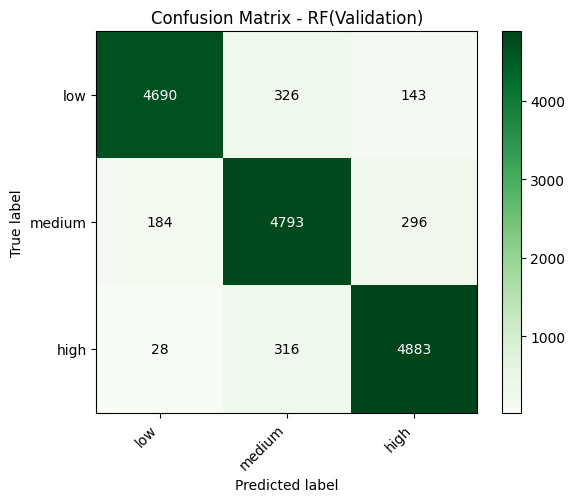

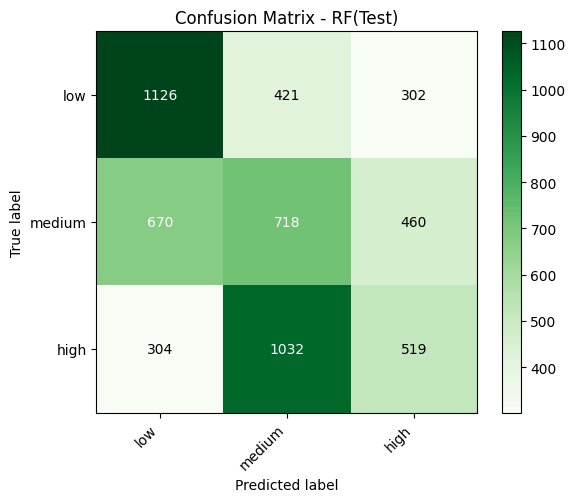

Loading participants: ['P01', 'P03', 'P04', 'P05', 'P06', 'P07', 'P08', 'P09', 'P10', 'P11', 'P12', 'P13', 'P14', 'P15']
Normalization method: participant_meanfree


Loading data:   7%|▋         | 1/14 [00:00<00:05,  2.41it/s]

PP01: mean-free → global z-scoring
   before: mean=-0.000, std=0.019
   after:  mean=0.000, std=1.000


Loading data:  14%|█▍        | 2/14 [00:01<00:09,  1.22it/s]

PP03: mean-free → global z-scoring
   before: mean=-0.000, std=0.017
   after:  mean=0.000, std=1.000


Loading data:  21%|██▏       | 3/14 [00:02<00:10,  1.08it/s]

PP04: mean-free → global z-scoring
   before: mean=-0.000, std=0.025
   after:  mean=-0.000, std=1.000


Loading data:  29%|██▊       | 4/14 [00:03<00:10,  1.09s/it]

PP05: mean-free → global z-scoring
   before: mean=-0.000, std=0.011
   after:  mean=0.000, std=1.000


Loading data:  36%|███▌      | 5/14 [00:05<00:10,  1.17s/it]

PP06: mean-free → global z-scoring
   before: mean=-0.000, std=0.024
   after:  mean=0.000, std=1.000


Loading data:  43%|████▎     | 6/14 [00:06<00:09,  1.17s/it]

PP07: mean-free → global z-scoring
   before: mean=0.000, std=0.010
   after:  mean=-0.000, std=1.000


Loading data:  50%|█████     | 7/14 [00:07<00:08,  1.14s/it]

PP08: mean-free → global z-scoring
   before: mean=-0.000, std=0.021
   after:  mean=-0.000, std=1.000


Loading data:  57%|█████▋    | 8/14 [00:08<00:07,  1.17s/it]

PP09: mean-free → global z-scoring
   before: mean=-0.000, std=0.017
   after:  mean=0.000, std=1.000


Loading data:  64%|██████▍   | 9/14 [00:09<00:05,  1.19s/it]

PP10: mean-free → global z-scoring
   before: mean=-0.000, std=0.018
   after:  mean=-0.000, std=1.000


Loading data:  71%|███████▏  | 10/14 [00:11<00:04,  1.16s/it]

PP11: mean-free → global z-scoring
   before: mean=-0.000, std=0.013
   after:  mean=-0.000, std=1.000


Loading data:  79%|███████▊  | 11/14 [00:12<00:03,  1.18s/it]

PP12: mean-free → global z-scoring
   before: mean=0.000, std=0.033
   after:  mean=-0.000, std=1.000


Loading data:  86%|████████▌ | 12/14 [00:13<00:02,  1.22s/it]

PP13: mean-free → global z-scoring
   before: mean=0.000, std=0.050
   after:  mean=-0.000, std=1.000


Loading data:  93%|█████████▎| 13/14 [00:14<00:01,  1.18s/it]

PP14: mean-free → global z-scoring
   before: mean=0.000, std=0.006
   after:  mean=0.000, std=1.000


Loading data: 100%|██████████| 14/14 [00:15<00:00,  1.12s/it]


PP15: mean-free → global z-scoring
   before: mean=-0.000, std=0.012
   after:  mean=0.000, std=1.000
low: 26291, medium: 26290, high: 26369
Loading participants: ['P02']
Normalization method: participant_meanfree


Loading data: 100%|██████████| 1/1 [00:00<00:00,  1.06it/s]

PP02: mean-free → global z-scoring
   before: mean=0.000, std=0.023
   after:  mean=0.000, std=1.000
low: 1631, medium: 1630, high: 1636


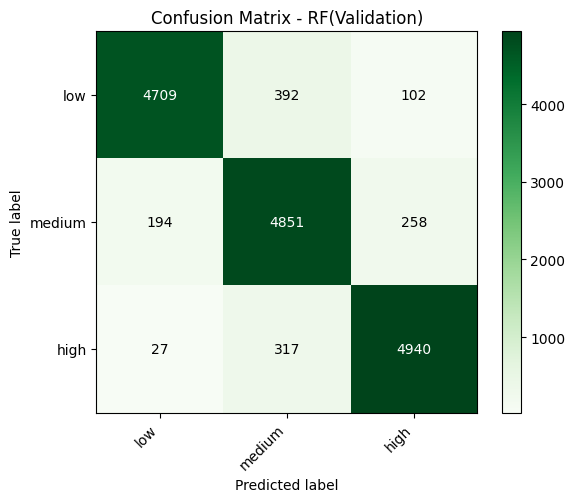

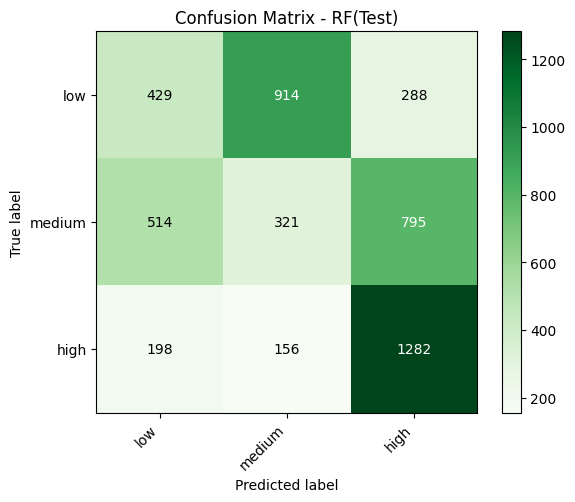

Loading participants: ['P02', 'P03', 'P04', 'P05', 'P06', 'P07', 'P08', 'P09', 'P10', 'P11', 'P12', 'P13', 'P14', 'P15']
Normalization method: participant_meanfree


Loading data:   7%|▋         | 1/14 [00:00<00:08,  1.54it/s]

PP02: mean-free → global z-scoring
   before: mean=0.000, std=0.023
   after:  mean=0.000, std=1.000


Loading data:  14%|█▍        | 2/14 [00:01<00:11,  1.08it/s]

PP03: mean-free → global z-scoring
   before: mean=-0.000, std=0.017
   after:  mean=0.000, std=1.000


Loading data:  21%|██▏       | 3/14 [00:02<00:10,  1.01it/s]

PP04: mean-free → global z-scoring
   before: mean=-0.000, std=0.025
   after:  mean=-0.000, std=1.000


Loading data:  29%|██▊       | 4/14 [00:04<00:11,  1.16s/it]

PP05: mean-free → global z-scoring
   before: mean=-0.000, std=0.011
   after:  mean=0.000, std=1.000


Loading data:  36%|███▌      | 5/14 [00:05<00:11,  1.23s/it]

PP06: mean-free → global z-scoring
   before: mean=-0.000, std=0.024
   after:  mean=0.000, std=1.000


Loading data:  43%|████▎     | 6/14 [00:06<00:09,  1.18s/it]

PP07: mean-free → global z-scoring
   before: mean=0.000, std=0.010
   after:  mean=-0.000, std=1.000


Loading data:  50%|█████     | 7/14 [00:07<00:08,  1.14s/it]

PP08: mean-free → global z-scoring
   before: mean=-0.000, std=0.021
   after:  mean=-0.000, std=1.000


Loading data:  57%|█████▋    | 8/14 [00:09<00:07,  1.18s/it]

PP09: mean-free → global z-scoring
   before: mean=-0.000, std=0.017
   after:  mean=0.000, std=1.000


Loading data:  64%|██████▍   | 9/14 [00:10<00:05,  1.19s/it]

PP10: mean-free → global z-scoring
   before: mean=-0.000, std=0.018
   after:  mean=-0.000, std=1.000


Loading data:  71%|███████▏  | 10/14 [00:11<00:04,  1.17s/it]

PP11: mean-free → global z-scoring
   before: mean=-0.000, std=0.013
   after:  mean=-0.000, std=1.000


Loading data:  79%|███████▊  | 11/14 [00:12<00:03,  1.22s/it]

PP12: mean-free → global z-scoring
   before: mean=0.000, std=0.033
   after:  mean=-0.000, std=1.000


Loading data:  86%|████████▌ | 12/14 [00:14<00:02,  1.29s/it]

PP13: mean-free → global z-scoring
   before: mean=0.000, std=0.050
   after:  mean=-0.000, std=1.000


Loading data:  93%|█████████▎| 13/14 [00:15<00:01,  1.21s/it]

PP14: mean-free → global z-scoring
   before: mean=0.000, std=0.006
   after:  mean=0.000, std=1.000


Loading data: 100%|██████████| 14/14 [00:16<00:00,  1.16s/it]


PP15: mean-free → global z-scoring
   before: mean=-0.000, std=0.012
   after:  mean=0.000, std=1.000
low: 27127, medium: 27127, high: 27208
Loading participants: ['P01']
Normalization method: participant_meanfree


Loading data: 100%|██████████| 1/1 [00:00<00:00,  2.32it/s]

PP01: mean-free → global z-scoring
   before: mean=-0.000, std=0.019
   after:  mean=0.000, std=1.000
low: 794, medium: 794, high: 797


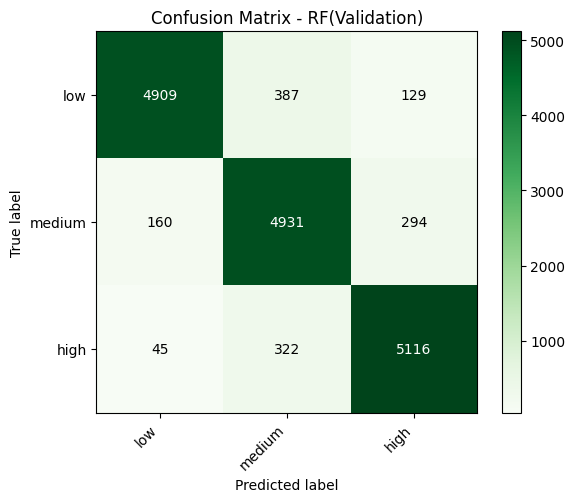

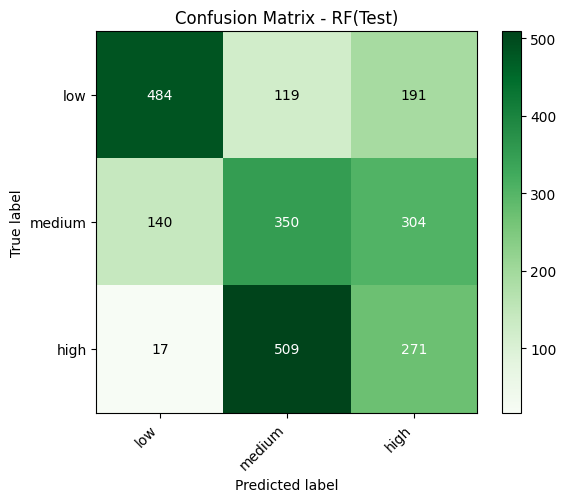

Loading participants: ['P01', 'P02', 'P03', 'P04', 'P05', 'P06', 'P07', 'P08', 'P09', 'P10', 'P11', 'P13', 'P14', 'P15']
Normalization method: participant_meanfree


Loading data:   7%|▋         | 1/14 [00:00<00:04,  3.01it/s]

PP01: mean-free → global z-scoring
   before: mean=-0.000, std=0.019
   after:  mean=0.000, std=1.000


Loading data:  14%|█▍        | 2/14 [00:01<00:07,  1.53it/s]

PP02: mean-free → global z-scoring
   before: mean=0.000, std=0.023
   after:  mean=0.000, std=1.000


Loading data:  21%|██▏       | 3/14 [00:02<00:09,  1.16it/s]

PP03: mean-free → global z-scoring
   before: mean=-0.000, std=0.017
   after:  mean=0.000, std=1.000


Loading data:  29%|██▊       | 4/14 [00:03<00:09,  1.05it/s]

PP04: mean-free → global z-scoring
   before: mean=-0.000, std=0.025
   after:  mean=-0.000, std=1.000


Loading data:  36%|███▌      | 5/14 [00:04<00:10,  1.14s/it]

PP05: mean-free → global z-scoring
   before: mean=-0.000, std=0.011
   after:  mean=0.000, std=1.000


Loading data:  43%|████▎     | 6/14 [00:06<00:09,  1.16s/it]

PP06: mean-free → global z-scoring
   before: mean=-0.000, std=0.024
   after:  mean=0.000, std=1.000


Loading data:  50%|█████     | 7/14 [00:07<00:07,  1.14s/it]

PP07: mean-free → global z-scoring
   before: mean=0.000, std=0.010
   after:  mean=-0.000, std=1.000


Loading data:  57%|█████▋    | 8/14 [00:08<00:06,  1.12s/it]

PP08: mean-free → global z-scoring
   before: mean=-0.000, std=0.021
   after:  mean=-0.000, std=1.000


Loading data:  64%|██████▍   | 9/14 [00:09<00:05,  1.12s/it]

PP09: mean-free → global z-scoring
   before: mean=-0.000, std=0.017
   after:  mean=0.000, std=1.000


Loading data:  71%|███████▏  | 10/14 [00:10<00:04,  1.11s/it]

PP10: mean-free → global z-scoring
   before: mean=-0.000, std=0.018
   after:  mean=-0.000, std=1.000


Loading data:  79%|███████▊  | 11/14 [00:11<00:03,  1.10s/it]

PP11: mean-free → global z-scoring
   before: mean=-0.000, std=0.013
   after:  mean=-0.000, std=1.000


Loading data:  86%|████████▌ | 12/14 [00:12<00:02,  1.12s/it]

PP13: mean-free → global z-scoring
   before: mean=0.000, std=0.050
   after:  mean=-0.000, std=1.000


Loading data:  93%|█████████▎| 13/14 [00:13<00:01,  1.10s/it]

PP14: mean-free → global z-scoring
   before: mean=0.000, std=0.006
   after:  mean=0.000, std=1.000


Loading data: 100%|██████████| 14/14 [00:14<00:00,  1.05s/it]


PP15: mean-free → global z-scoring
   before: mean=-0.000, std=0.012
   after:  mean=0.000, std=1.000
low: 25819, medium: 25819, high: 25897
Loading participants: ['P12']
Normalization method: participant_meanfree


Loading data: 100%|██████████| 1/1 [00:01<00:00,  1.29s/it]

PP12: mean-free → global z-scoring
   before: mean=0.000, std=0.033
   after:  mean=-0.000, std=1.000
low: 2102, medium: 2102, high: 2108


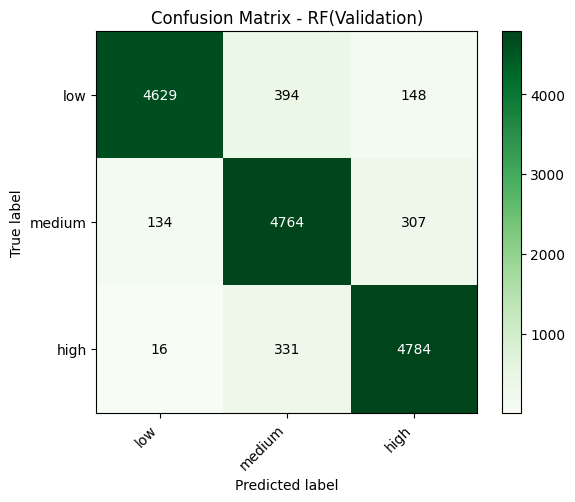

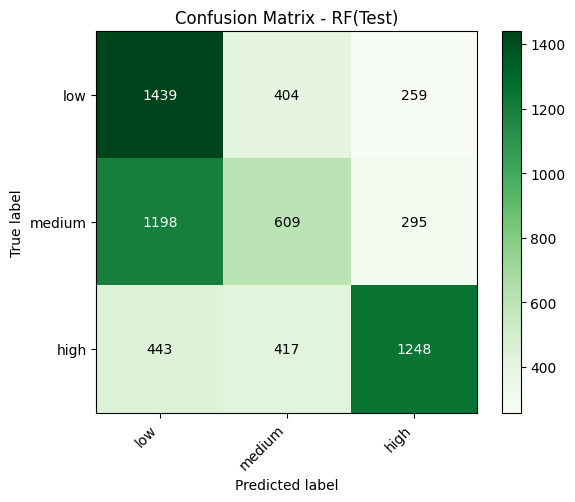

Loading participants: ['P01', 'P02', 'P03', 'P04', 'P06', 'P07', 'P08', 'P09', 'P10', 'P11', 'P12', 'P13', 'P14', 'P15']
Normalization method: participant_meanfree


Loading data:   7%|▋         | 1/14 [00:00<00:06,  1.89it/s]

PP01: mean-free → global z-scoring
   before: mean=-0.000, std=0.019
   after:  mean=-0.000, std=1.000


Loading data:  14%|█▍        | 2/14 [00:01<00:08,  1.40it/s]

PP02: mean-free → global z-scoring
   before: mean=0.000, std=0.023
   after:  mean=0.000, std=1.000


Loading data:  21%|██▏       | 3/14 [00:02<00:09,  1.15it/s]

PP03: mean-free → global z-scoring
   before: mean=-0.000, std=0.017
   after:  mean=0.000, std=1.000


Loading data:  29%|██▊       | 4/14 [00:03<00:09,  1.10it/s]

PP04: mean-free → global z-scoring
   before: mean=-0.000, std=0.025
   after:  mean=-0.000, std=1.000


Loading data:  36%|███▌      | 5/14 [00:04<00:08,  1.02it/s]

PP06: mean-free → global z-scoring
   before: mean=-0.000, std=0.024
   after:  mean=0.000, std=1.000


Loading data:  43%|████▎     | 6/14 [00:05<00:07,  1.02it/s]

PP07: mean-free → global z-scoring
   before: mean=0.000, std=0.010
   after:  mean=-0.000, std=1.000


Loading data:  50%|█████     | 7/14 [00:06<00:06,  1.01it/s]

PP08: mean-free → global z-scoring
   before: mean=-0.000, std=0.021
   after:  mean=-0.000, std=1.000


Loading data:  57%|█████▋    | 8/14 [00:07<00:06,  1.03s/it]

PP09: mean-free → global z-scoring
   before: mean=-0.000, std=0.017
   after:  mean=0.000, std=1.000


Loading data:  64%|██████▍   | 9/14 [00:08<00:05,  1.07s/it]

PP10: mean-free → global z-scoring
   before: mean=-0.000, std=0.018
   after:  mean=-0.000, std=1.000


Loading data:  71%|███████▏  | 10/14 [00:09<00:04,  1.08s/it]

PP11: mean-free → global z-scoring
   before: mean=-0.000, std=0.013
   after:  mean=-0.000, std=1.000


Loading data:  79%|███████▊  | 11/14 [00:11<00:03,  1.14s/it]

PP12: mean-free → global z-scoring
   before: mean=0.000, std=0.033
   after:  mean=-0.000, std=1.000


Loading data:  86%|████████▌ | 12/14 [00:12<00:02,  1.20s/it]

PP13: mean-free → global z-scoring
   before: mean=0.000, std=0.050
   after:  mean=-0.000, std=1.000


Loading data:  93%|█████████▎| 13/14 [00:13<00:01,  1.18s/it]

PP14: mean-free → global z-scoring
   before: mean=0.000, std=0.006
   after:  mean=0.000, std=1.000


Loading data: 100%|██████████| 14/14 [00:14<00:00,  1.05s/it]


PP15: mean-free → global z-scoring
   before: mean=-0.000, std=0.012
   after:  mean=0.000, std=1.000
low: 25730, medium: 25730, high: 25808
Loading participants: ['P05']
Normalization method: participant_meanfree


Loading data: 100%|██████████| 1/1 [00:01<00:00,  1.34s/it]

PP05: mean-free → global z-scoring
   before: mean=-0.000, std=0.011
   after:  mean=0.000, std=1.000
low: 2191, medium: 2190, high: 2198


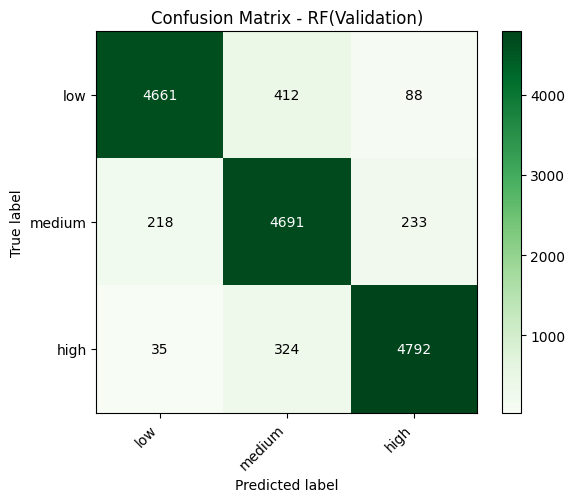

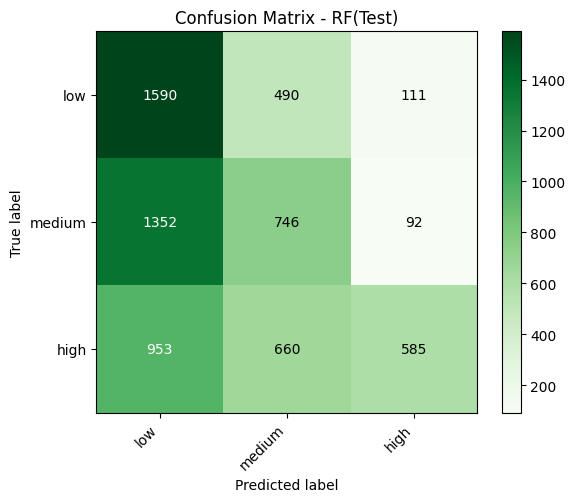

In [22]:
rf_val_acc = []
rf_test_acc = []
rf_val_roc_auc = []
rf_test_roc_auc = []

for fold_index in range(0, 5):
    X_train, y_train, _ = load_dataset(participant=folds[fold_index][0], paths=dataset_dir, z_score_norm="participant_meanfree")
    y_train_cat, y_train_lbl = assign_classification_labels(y_train)
    X_test, y_test, _ = load_dataset(participant=folds[fold_index][1], paths=dataset_dir, z_score_norm="participant_meanfree")
    y_test_cat, y_test_lbl = assign_classification_labels(y_test)
    
    X_tr, X_val, y_tr, y_val = train_test_split(X_train, y_train_cat, test_size=0.2, random_state=42)
    
    rf_model = build_rf_pipeline()
    rf_model = train_pipeline(rf_model, X_tr, y_tr)
    joblib.dump(rf_model, f'final_result/rf_model_fold{fold_index}.pkl')
    
    
    val_metrics = compute_metrics(rf_model, X_val, y_val, n_classes, class_names)

    plot_confusion_matrix(val_metrics['conf_matrix'], class_names,
                          title=f"Confusion Matrix - RF(Validation)", cmap="Greens", save_path=f"final_result/rf_3cat_fold{fold_index}.pdf")

    # Evaluate test
    test_metrics = compute_metrics(rf_model, X_test, y_test_cat, n_classes, class_names)
    plot_confusion_matrix(test_metrics['conf_matrix'], class_names,
                          title=f"Confusion Matrix - RF(Test)", cmap="Greens", save_path=f"final_result/rf_3cat_test_fold{fold_index}.pdf")
    
    
    rf_val_acc.append(val_metrics["accuracy"])
    rf_test_acc.append(test_metrics["accuracy"])
    rf_val_roc_auc.append(val_metrics["roc"]["auc"]["micro"])
    rf_test_roc_auc.append(test_metrics["roc"]["auc"]["micro"])
    
    
    
rf_metrics_to_save = {
    "fold_index": [0, 1, 2, 3, 4],
    "val_accuracy": rf_val_acc,
    "roc_auc_micro": rf_val_roc_auc,
    "test_accuracy": rf_test_acc,
    "roc_auc_micro_test": rf_test_roc_auc,
    
}

# Convert to DataFrame and save
df = pd.DataFrame(rf_metrics_to_save)
df.to_csv(f"final_result/rf_cross_validation_metrics_meanfree.csv", index=False)

## Comparison

In [24]:
df_global = pd.read_csv("final_result/rf_cross_validation_metrics_global.csv")
df_meanfree = pd.read_csv("final_result/rf_cross_validation_metrics_meanfree.csv")



print("Global Normalization:")
print(df_global)
print("--------------------------------")
print("Mean-Free Normalization:")
print(df_meanfree)

Global Normalization:
   fold_index  val_accuracy  roc_auc_micro  test_accuracy  roc_auc_micro_test
0           0      0.900696       0.981347       0.334834            0.501565
1           1      0.887460       0.978645       0.335103            0.496688
2           2      0.890014       0.978132       0.410901            0.567664
3           3      0.878120       0.973916       0.351869            0.561236
4           4      0.897243       0.980824       0.428029            0.531764
--------------------------------
Mean-Free Normalization:
   fold_index  val_accuracy  roc_auc_micro  test_accuracy  roc_auc_micro_test
0           0      0.917428       0.987908       0.425612            0.570582
1           1      0.918303       0.987287       0.414948            0.621437
2           2      0.917940       0.987865       0.463312            0.671670
3           3      0.914232       0.985788       0.522180            0.720826
4           4      0.915232       0.986065       0.443988     

# Result:
Same results observed for mean-free participant
--------